In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import itertools
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend, models, layers, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split # This method ended up not being used
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from IPython.display import display # This library ended up not being used.
from PIL import Image # This library was used to help view images
from tensorflow.keras.preprocessing.image import ImageDataGenerator # This library was used for data augmentation
import os, shutil # This libraries were used to create file connections
import cv2
np.random.seed(42)

import pandas as pd
import numpy as np
import itertools
import keras 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers 
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime
import time
import tensorflow as tf

In [ ]:
backend.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Specify the base directory where images are located.  You need to save your data here.
base_dir = '/gdrive/My Drive/Regis/Karoo/Ctrl_Data_Slim/'

In [ ]:
# https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa

In [ ]:
# Creating dimensions and connecting to images 
# The default dimensions for the Animal_10 dataset
img_width, img_height = 224, 224

#Bottleneck File
top_model_weights_path = '/gdrive/My Drive/Regis/Karoo/bottleneck_fc_model.h5/'

# loading up our datasets
train_data_dir = '/gdrive/My Drive/Regis/Karoo/Ctrl_Data_Slim/Train'
validation_data_dir = '/gdrive/My Drive/Regis/Karoo/Ctrl_Data_Slim/Val'
test_data_dir = '/gdrive/My Drive/Regis/Karoo/Ctrl_Data_Slim/Test'


epochs = 30 
batch_size = 10 

In [ ]:
# Loading ResNet101 
ResNet101 = applications.ResNet101(include_top=False, weights='imagenet', input_shape = (224, 224, 3))

datagen = ImageDataGenerator(rescale=1. / 255)
# needed to create the bottleneck .npy files

171450368/171446536 [==============================] - 2s 0us/step


In [ ]:
# Creating Training Data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = ResNet101.predict_generator(generator,
                                                    predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end = datetime.datetime.now()
elapsed = end-start
print ('Time: ', elapsed)

Found 788 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:11:15.049515


In [ ]:
#Creating Validation Data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_val_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_val = int(math.ceil(nb_val_samples / batch_size))

bottleneck_features_val = ResNet101.predict_generator(generator,
                                                    predict_size_val)

np.save('bottleneck_features_val.npy', bottleneck_features_val)
end = datetime.datetime.now()
elapsed = end-start
print ('Time: ', elapsed)

Found 197 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:02:43.636500


In [ ]:
# Creating Test Data
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_test_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = ResNet101.predict_generator(generator,
                                                    predict_size_test)

np.save('bottleneck_features_test.npy', bottleneck_features_test)
end = datetime.datetime.now()
elapsed = end-start
print ('Time: ', elapsed)

Found 246 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:03:19.724791


In [ ]:
# Processing Training Data 
train_generator_top = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False)

nb_train_samples = len(train_generator_top.filenames)
num_classes = len(train_generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class labels for the training data, in the original order
train_labels = train_generator_top.classes

# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 788 images belonging to 3 classes.


In [ ]:
# Processing Validation Data 
validation_generator_top = datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False)

nb_val_samples = len(validation_generator_top.filenames)
num_classes = len(validation_generator_top.class_indices)

# load the bottleneck features saved earlier
val_data = np.load('bottleneck_features_val.npy')

# get the class labels for the training data, in the original order
val_labels = validation_generator_top.classes

# convert the training labels to categorical vectors
val_labels = to_categorical(val_labels, num_classes=num_classes)

Found 197 images belonging to 3 classes.


In [ ]:
# Processing Test Data 
test_generator_top = datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False)

nb_test_samples = len(test_generator_top.filenames)
num_classes = len(test_generator_top.class_indices)

# load the bottleneck features saved earlier
test_data = np.load('bottleneck_features_test.npy')

# get the class labels for the training data, in the original order
test_labels = test_generator_top.classes

# convert the training labels to categorical vectors
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 246 images belonging to 3 classes.


In [ ]:
# Creating our Convolutional Neural Network Code: 
start = datetime.datetime.now()
model = Sequential()
model.add (Flatten (input_shape=train_data.shape[1:]))
model.add(Dense (100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout (0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(val_data, val_labels))

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(
    val_data, val_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/30
79/79 [==============================] - 8s 92ms/step - loss: 2.0778 - acc: 0.3271 - val_loss: 1.3300 - val_acc: 0.3503
Epoch 2/30
79/79 [==============================] - 7s 86ms/step - loss: 1.6007 - acc: 0.4135 - val_loss: 1.1176 - val_acc: 0.5533
Epoch 3/30
79/79 [==============================] - 7s 87ms/step - loss: 1.5447 - acc: 0.4174 - val_loss: 0.9265 - val_acc: 0.5381
Epoch 4/30
79/79 [==============================] - 7s 87ms/step - loss: 1.4580 - acc: 0.4443 - val_loss: 1.0051 - val_acc: 0.5127
Epoch 5/30
79/79 [==============================] - 7s 87ms/step - loss: 1.3651 - acc: 0.4842 - val_loss: 1.2024 - val_acc: 0.4772
Epoch 6/30
79/79 [==============================] - 7s 86ms/step - loss: 1.3380 - acc: 0.4650 - val_loss: 1.3467 - val_acc: 0.4772
Epoch 7/30
79/79 [==============================] - 7s 86ms/step - loss: 1.3674 - acc: 0.4773 - val_loss: 1.8918 - val_acc: 0.4721
Epoch 8/30
79/79 [==============================] - 7s 87ms/step - loss: 1.3483 - a

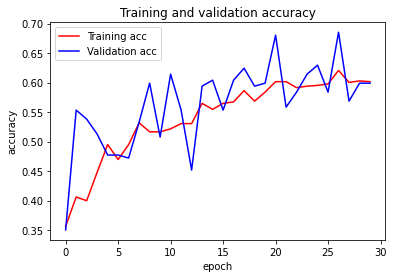

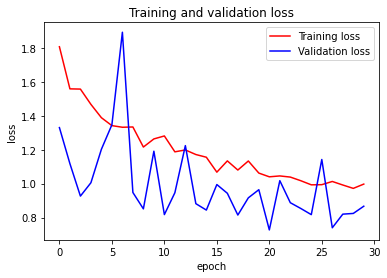

In [ ]:
# Code for visulization of the Accuracy and Loss: 
# Graphing our training and validation 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

8/8 [==============================] - 0s 15ms/step - loss: 0.7943 - acc: 0.6382


[0.7942678332328796, 0.6382113695144653]

In [ ]:
preds = np.round(model.predict(test_data),0)
print('rounded test_labels', preds)

rounded test_labels [[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 

In [ ]:
animals = ['Eland', 'Kudu_Bull', 'Mountain_Zebra']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

                precision    recall  f1-score   support

         Eland       0.68      0.33      0.44        86
     Kudu_Bull       0.84      0.46      0.60        80
Mountain_Zebra       0.61      0.90      0.72        80

     micro avg       0.67      0.56      0.61       246
     macro avg       0.71      0.56      0.59       246
  weighted avg       0.71      0.56      0.58       246
   samples avg       0.56      0.56      0.56       246



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Creating our confusion matrix

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

# Displaying the confusion matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
# Creating the option for normalization:

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]
    print("Normalized confusion matrix")
  else: 
    print('Confusion matrix, without normalization')

# Printing the confusion matrix

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 

Normalized confusion matrix


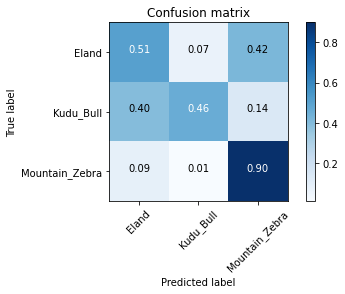

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(confusion_matrix, ['Eland', 'Kudu_Bull', 'Mountain_Zebra'], normalize=True)

Mamun, Iftekher (April 7th, 2019) A Simple CNN: Multi Image Classifier. [Towards Data Science] Retrieved from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa